![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

<div class="alert alert-warning">
This notebook still needs to go through revision.
</div>

# SVD and DMD analysis of airfoil surface data

In this notebook, we perform DMD on a more challenging example. We are presented with surface data from an *OpenFOAM* IDDES simulation of a NACA-0012 airfoil in transonic flow conditions. In the simulation, a *pressure* function object computes the total pressure coefficient on the airfoil's surface, and a *surfaces* function object samples the surface and outputs the data as raw text files. The Reynolds number based on the chord length $c$, the freestream velocity $U_\infty$, and the kinematic viscosity $\nu$ is $Re=U_\infty c / \nu = 10^7$. The freestream Mach number is $Ma=0.75$. At $\alpha = 4^\circ$ angle of attack, the airfoil experiences the so-called transonic shock buffet, which we analyze in this notebook. The simulation setup is available in [this repository](https://github.com/AndreWeiner/naca0012_shock_buffet).

In [1]:
import bisect
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch import DATASETS
from flowtorch.data import CSVDataloader, mask_box
from flowtorch.analysis import SVD
from flowtorch.analysis import DMD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Assembling the data matrix

The data consist of raw text files organized in time folders. The text files have four columns, one for each coordinate of the sample locations and one for the field value, which is the pressure coefficient in the present case. The `CSVDataloader` in *flowTorch* has a class method that simplifies loading *OpenFOAM* surface sample data.

In [2]:
path = DATASETS["csv_naca0012_alpha4_surface"]
loader = CSVDataloader.from_foam_surface(path, "total(p)_coeff_airfoil.raw", "cp")
times = loader.write_times
print(f"Found {len(times)} snapshots ranging from {times[0]}s to {times[-1]}s.")

Found 250 snapshots ranging from 0.001s to 0.25s.


First, we load all available snapshots into the data matrix to estimate roughly when the initial transient is over. Later on, we work with a subset of the data matrix. The shock and the shock motion is present on the airfoil's upper side. Therefore, we select only the upper side for the analysis. Before creating the selection mask, we also normalize the position vectors with the chord length. The latter step is only for visualization. 

In [3]:
vertices = loader.vertices
vertices /= (vertices[:, 0].max() - vertices[:, 0].min())
mask = mask_box(vertices, lower=[-1.0, 0.0, -1.0], upper=[0.9999, 1.0, 1.0])
points_upper = mask.sum().item()
print(f"Select {points_upper} out of {mask.shape[0]} vertices.")

Select 13950 out of 28892 vertices.


In [4]:
data_matrix = pt.zeros((points_upper, len(times)), dtype=pt.float32)
for i, time in enumerate(times):
    snapshot = loader.load_snapshot("cp", time)
    data_matrix[:, i] = pt.masked_select(snapshot, mask)

## Inspecting the data

In the next cells, we perform the following steps:
- visualize several snapshots to verify that the preprocessing was successful and to get a first impression of the data
- plot $c_p$ averaged in space and time for time windows of increasing size
- visualize the temporal mean distribution of $c_p$

In [5]:
def add_surface_plot_to_axis(ax, vertices, field):
    f_min, f_max = field.min(), field.max()
    tri = ax.tricontourf(vertices[:, 0], vertices[:, 1], field, levels=15, cmap="jet", vmin=f_min, vmax=f_max)
    ax.set_aspect("equal", 'box')
    cbar = plt.colorbar(tri, ax=ax, ticks=[0.8*f_min, 0.5*(f_max+f_min), 0.8*f_max], aspect=10)
    cbar.ax.tick_params(labelsize=8)

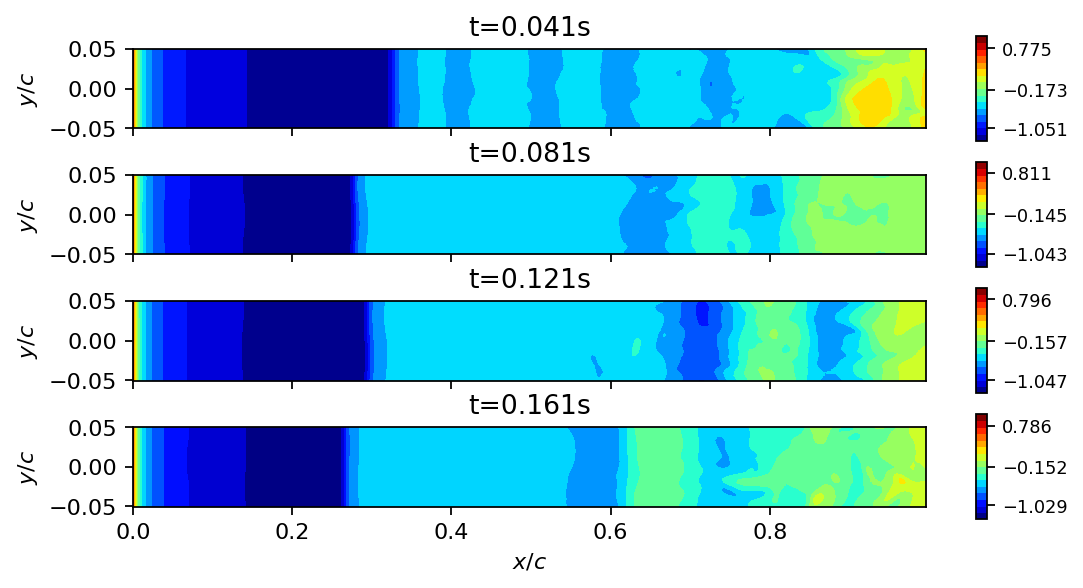

In [6]:
vertices_upper = pt.zeros((points_upper, 2), dtype=pt.float32)
vertices_upper[:, 0] = pt.masked_select(vertices[:, 0], mask)
vertices_upper[:, 1] = pt.masked_select(vertices[:, 2], mask)

fig, axarr = plt.subplots(4, 1, figsize=(8, 4), sharex=True)

for ax, i in zip(axarr, [40, 80, 120, 160]):
    add_surface_plot_to_axis(ax, vertices_upper, data_matrix[:, i])
    ax.set_ylabel(r"$y/c$")
    ax.set_title(f"t={times[i]}s")
    
axarr[-1].set_xlabel(r"$x/c$")
plt.show()

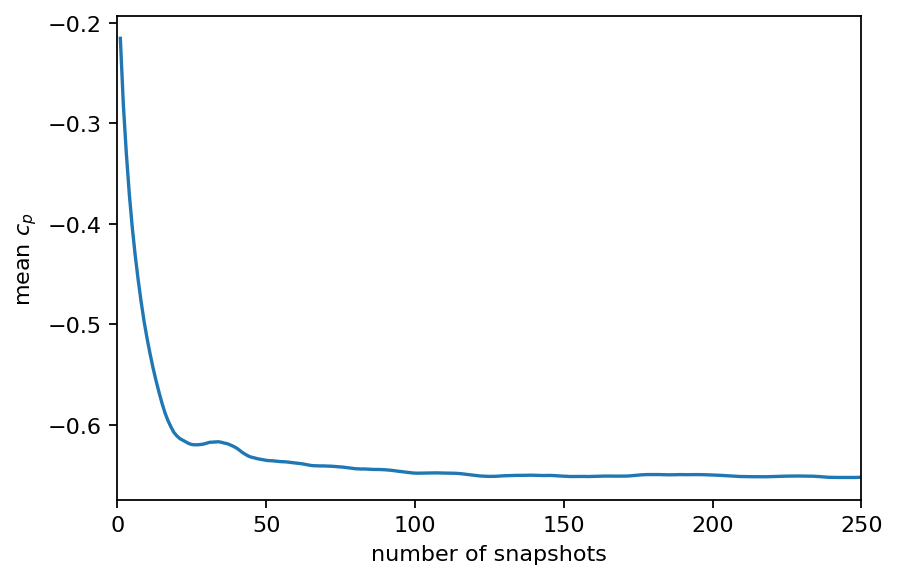

In [7]:
mean_cp = [data_matrix[:, :i].mean() for i in range(1, len(times)+1)]

fig, ax = plt.subplots()
ax.plot(range(1, len(times)+1), mean_cp)
ax.set_xlabel("number of snapshots")
ax.set_ylabel(r"mean $c_p$")
ax.set_xlim(0, len(times))
plt.show()

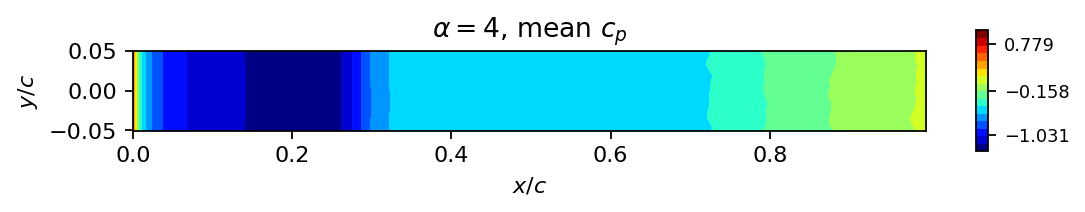

In [8]:
# we compute the mean starting from the 100th snapshot
cp_mean = pt.mean(data_matrix[:, 100:], dim=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 1), sharex=True)
add_surface_plot_to_axis(ax, vertices_upper, cp_mean)
ax.set_xlabel(r"$x/c$")
ax.set_ylabel(r"$y/c$")
ax.set_title(r"$\alpha = 4$, mean $c_p$")
plt.show()

## Singular value decomposition

In [9]:
data_matrix = data_matrix[:, 100:] - data_matrix[:, 100:].mean(dim=1).unsqueeze(-1)
svd = SVD(data_matrix, rank=200)
print(svd)

SVD of a 13950x150 data matrix
Selected/optimal rank: 150/51
data type: torch.float32 (4b)
truncated SVD size: 8.0687Mb


In [10]:
s = svd.s
s_sum = s.sum().item()
# relative contribution
s_rel = [s_i / s_sum * 100 for s_i in s]
# cumulative contribution
s_cum = [s[:n].sum().item() / s_sum * 100 for n in range(s.shape[0])]
# find out how many singular values we need to reach at least 99 percent
i_99 = bisect.bisect_right(s_cum, 99)

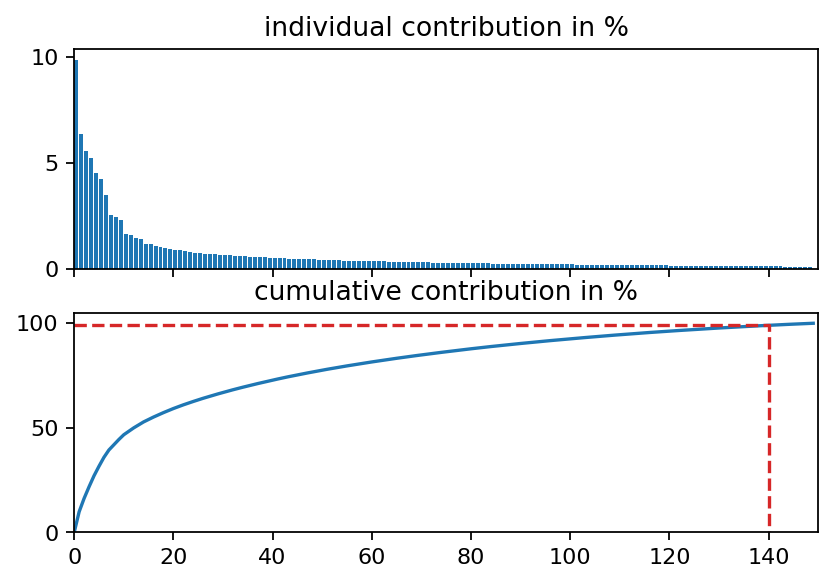

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(range(s.shape[0]), s_rel, align="edge")
ax2.plot(range(s.shape[0]), s_cum)
ax2.set_xlim(0, 150)
ax2.set_ylim(0, 105)
ax1.set_title("individual contribution in %")
ax2.set_title("cumulative contribution in %")
ax2.plot([0, i_99, i_99], [s_cum[i_99], s_cum[i_99], 0], ls="--", color="C3")
plt.show()

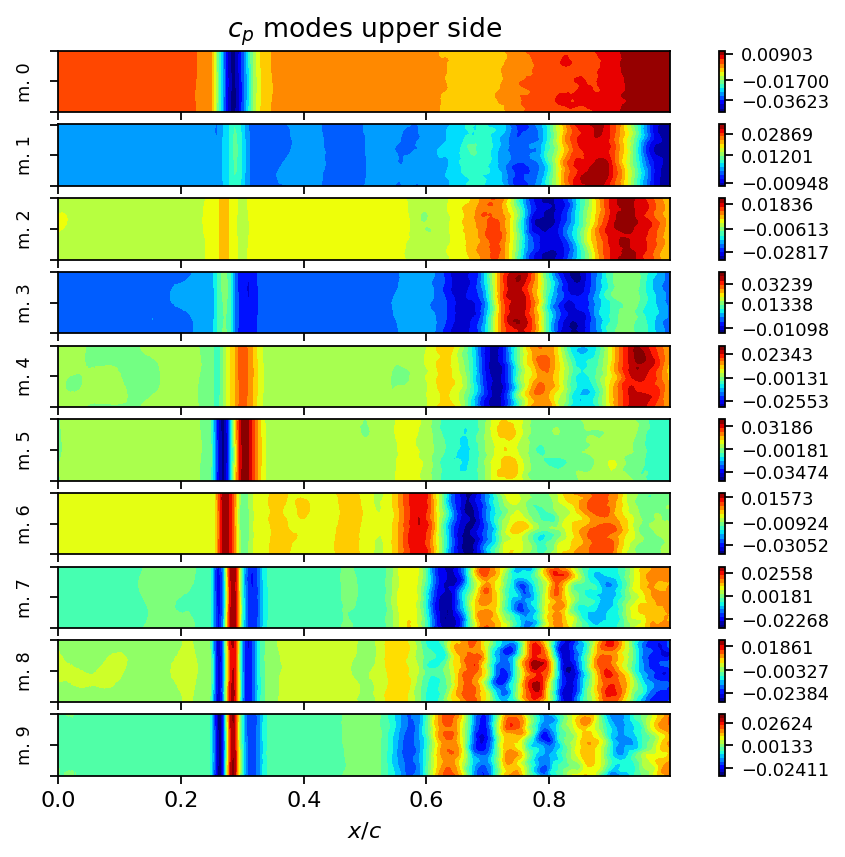

In [12]:
modes = list(range(10))
height = 0.6

fig, axarr = plt.subplots(len(modes), 1, figsize=(8, height*len(modes)), sharex=True, sharey=True)
for row in range(len(modes)):
    add_surface_plot_to_axis(axarr[row], vertices_upper, svd.U[:, row])
    axarr[row].set_ylabel(f"m. {row}", fontsize=8)
    axarr[row].set_yticklabels([])
axarr[0].set_title(r"$c_p$ modes upper side")
axarr[-1].set_xlabel(r"$x/c$")
plt.show()

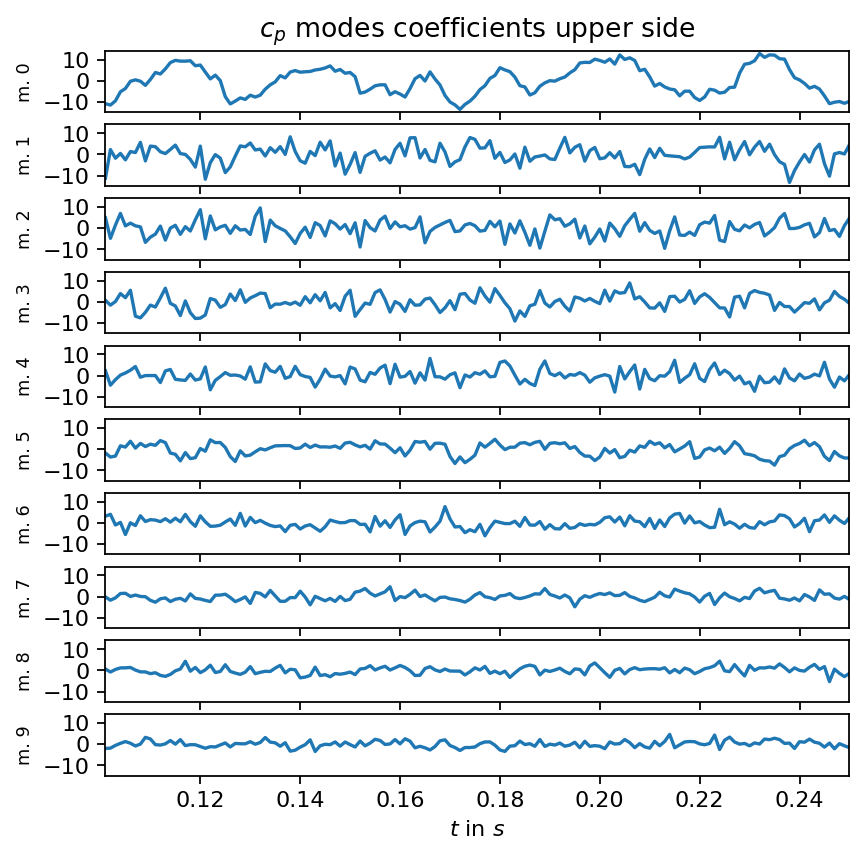

In [13]:
times_num = [float(t) for t in times[100:]]
height = 0.6

fig, axarr = plt.subplots(len(modes), 1, figsize=(6, height*len(modes)), sharex=True, sharey=True)
for row in range(len(modes)):
    axarr[row].plot(times_num, svd.V[:, row]*svd.s[row])
    axarr[row].set_ylabel(f"m. {row}", fontsize=8)
    #axarr[row].set_yticklabels([])
axarr[0].set_title(r"$c_p$ modes coefficients upper side")
axarr[-1].set_xlim(times_num[0], times_num[-1])
axarr[-1].set_xlabel(r"$t$ in $s$")
plt.show()

## Dynamic mode decomposition

What the DMD offers as in contrast to the SVD is direct information about frequencies and amplitudes of coherent structures in the data.

In [14]:
dt = times_num[1] - times_num[0]
dmd = DMD(data_matrix, dt, rank=200)
print(dmd)

SVD:
SVD of a 13950x149 data matrix
Selected/optimal rank: 149/51
data type: torch.float32 (4b)
truncated SVD size: 8.0143Mb
LSQ:
Overall DMD size: 24.0429Mb


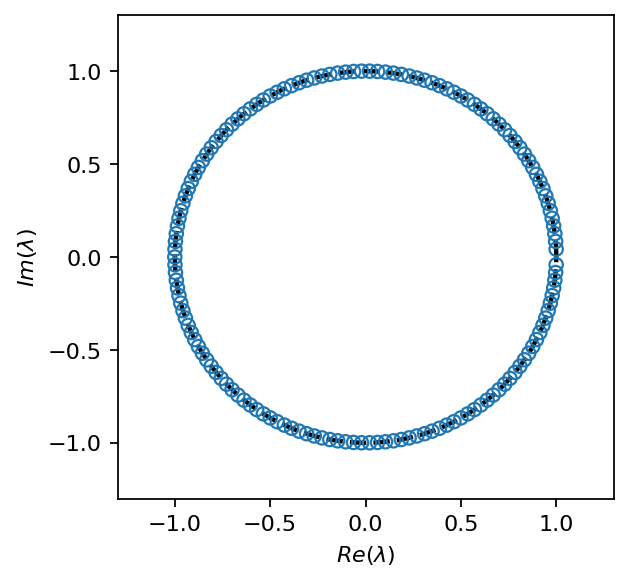

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, facecolors='none', edgecolors="C0", zorder=7)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
plt.show()

The buffet frequency reported in [Static and Dynamic Pressure Measurements on a NACA 0012 Airfoil in the Ames High Reynolds Number Facility](https://ntrs.nasa.gov/citations/19850019511) by J. B. McDevitt and A. F. Okuno is about $31 Hz$ (set 1 flow conditions in the report). This frequency was obtained from pressure measurement at $50\%$ chord on the upper side of the airfoil. The spectrum visualized below contains vertical lines at the buffet frequency and multiples of buffet frequency. The markers are scaled by the DMD modes' magnitude. We see that there are several modes very close to the buffet frequency. In particular, mode 13 seems to be interesting since it has a large magnitude and is close to the buffet frequency.

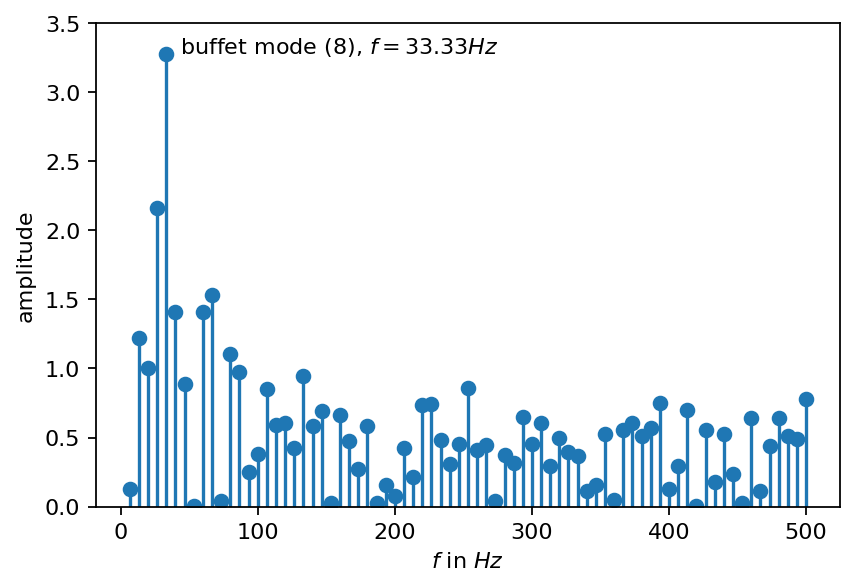

In [16]:
amplitude = dmd.amplitude.real.abs()
freq = dmd.frequency
freq_i_pos = (freq > 0).nonzero().flatten()

fig, ax= plt.subplots()
ax.stem(freq[freq_i_pos].numpy(), amplitude[freq_i_pos].numpy(), basefmt="none")
_, top_pos = amplitude[freq_i_pos].topk(1)
top_i = freq_i_pos[top_pos].item()
ax.text(freq[top_i]+10, amplitude[top_i], r"buffet mode ({:d}), $f={:2.2f}Hz$".format(top_i, freq[top_i]))
ax.set_ylim(0, 3.5)
ax.set_xlabel(r"$f$ in $Hz$")
ax.set_ylabel("amplitude")
plt.show()

A DMD mode shows us, which regions fluctuate jointly at the frequency associated the the mode. In the modes 8 and 6, we see a strong correlation between the shock and the separated boundary layer: the pressure coefficient increases where the boundary layer separates, while it drops around the shock. We now have initial proof that shock motion and boundary layer separation are connected. Because the region between the shock and the separated boundary layer does not oscillate at the same frequency, we may assume that the connection between the two flow patterns happens somewhere within the flow above the upper surface, which we can not analyze with the present dataset.

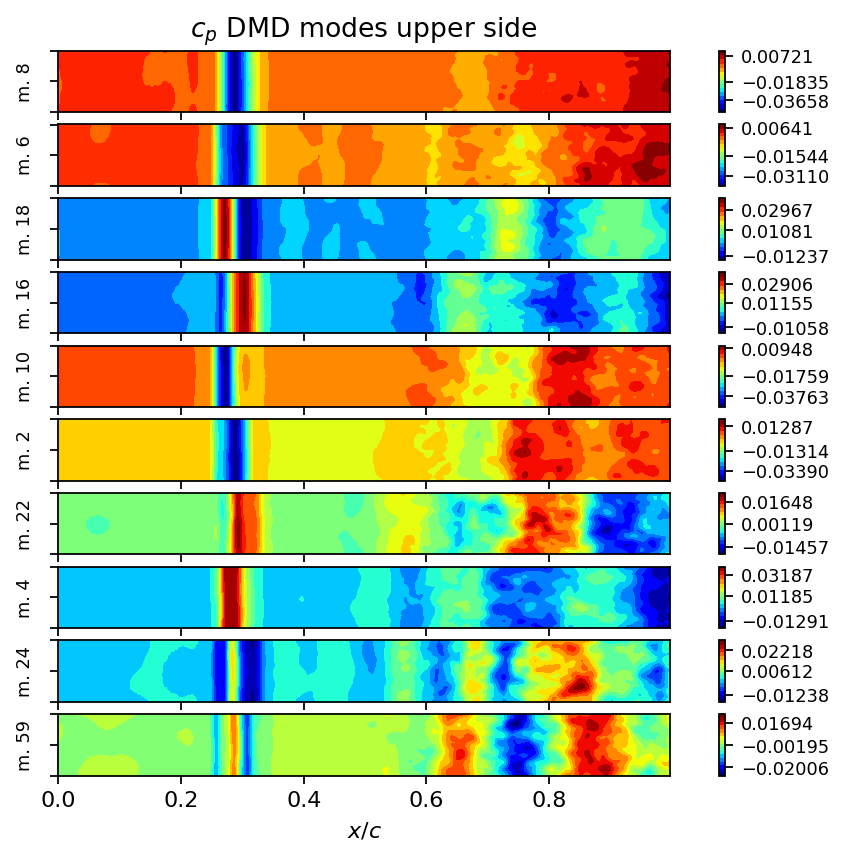

In [17]:
_, top_pos = amplitude[freq_i_pos].topk(10)
top_i = freq_i_pos[top_pos]

fig, axarr = plt.subplots(len(modes), 1, figsize=(8, height*len(modes)), sharex=True, sharey=True)
for row, mode_i in enumerate(top_i):
    add_surface_plot_to_axis(axarr[row], vertices_upper, dmd.modes[:, mode_i].real)
    axarr[row].set_ylabel(f"m. {mode_i}", fontsize=8)
    axarr[row].set_yticklabels([])
axarr[0].set_title(r"$c_p$ DMD modes upper side")
axarr[-1].set_xlabel(r"$x/c$")
plt.show()

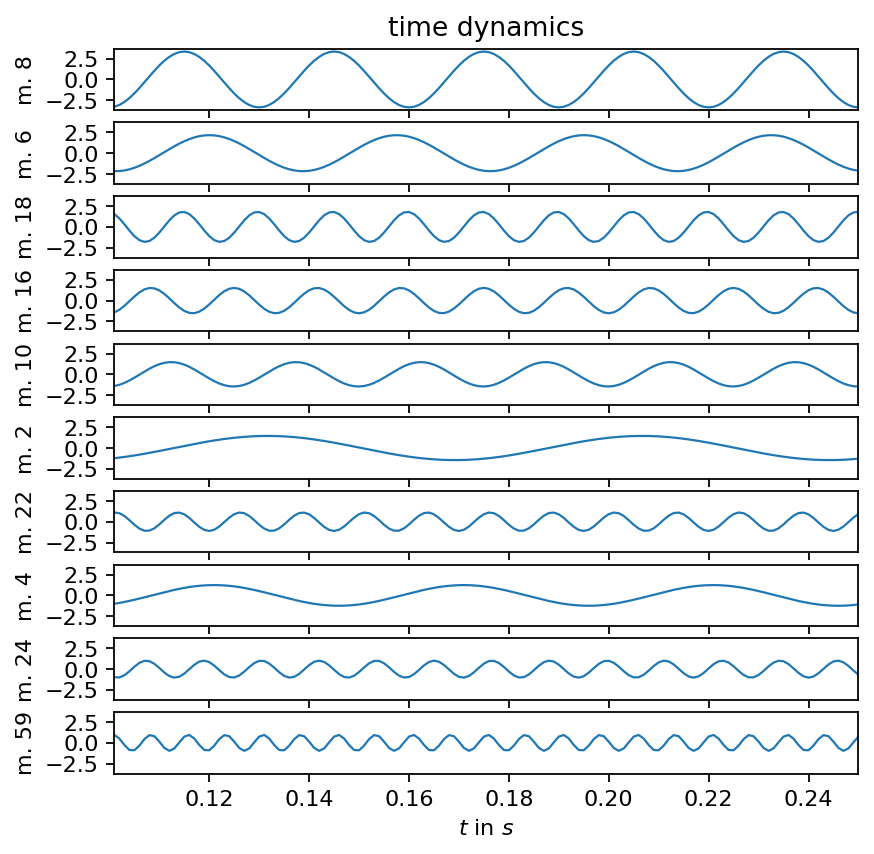

In [18]:
fig, axarr = plt.subplots(len(modes), 1, figsize=(6, height*len(modes)), sharex=True, sharey=True)

for i, mode_i in enumerate(top_i):
    axarr[i].plot(times_num, dmd.dynamics[mode_i].real, lw=1)
    axarr[i].set_ylabel(f"m. {mode_i}")
axarr[-1].set_xlabel(r"$t$ in $s$")
axarr[-1].set_xlim(times_num[0], times_num[-1])
axarr[0].set_title("time dynamics")
plt.show()